# Machine Learning Project 

In [65]:
# General
import json
import warnings
import time
import os
import copy
import pickle
import random
#import utils
from datetime import datetime
from datetime import timedelta
import dateutil.parser

# Data Collection and Processing
from pandas_datareader import DataReader
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook, tnrange
from yahoo_earnings_calendar import YahooEarningsCalendar

# Statistics and Modelling
import statsmodels.api as sm
from scipy.stats import kurtosis
from pmdarima import auto_arima
import pmdarima as pm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import talib
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Config
%matplotlib inline
%config InlineBackend.figure_format='retina'
warnings.filterwarnings("ignore")

## 1. Download - Stock - 20 years - Daily : Open, Close, High , Low , Volume

In [66]:
import yfinance as yf
TICKER = 'MSFT'
df = pd.read_csv(f'{TICKER}.csv')
df['Date'] = pd.to_datetime(df['Date'])

## F-F % Factor model - Factors 

ff = pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily.CSV')
ff['Date'] = pd.to_datetime(ff['Date'], format='%Y%m%d')
all_df = pd.merge(df[['Date', 'Close', 'Volume']], ff, on='Date', how='left')

all_df = all_df.dropna()
all_df['Return'] = all_df['Close']/all_df['Close'].shift(1) - 1
all_df.dropna(inplace=True)
all_df.head()

,Date,Close,Volume,Mkt-RF,SMB,HML,RMW,CMA,RF,Return
1,1986-03-14,0.063809,308160000,1.03,-0.83,-0.22,0.12,0.30,0.03,0.035713
2,1986-03-17,0.064909,133171200,-0.75,0.00,-0.32,0.39,0.03,0.03,0.017249
3,1986-03-18,0.063258,67766400,0.47,0.04,-0.17,-0.08,0.28,0.03,-0.025431
4,1986-03-19,0.062158,47894400,-0.17,0.15,-0.09,0.14,0.23,0.03,-0.017391
5,1986-03-20,0.060508,58435200,0.39,-0.13,-0.02,0.12,0.12,0.03,-0.026547


###  Earnings  Data Downlaod  

In [54]:
earnings_df = pd.read_csv(f'earnings_{TICKER}.csv')

# Convert Date column to datetime
earnings_df['Date'] = pd.to_datetime(earnings_df['report_date'])

edf = earnings_df[['Date']]
edf['earnings'] = 1

all_df = pd.merge(all_df, edf, on='Date', how='left')
all_df = all_df.fillna(0)

print(f'There are {all_df.earnings.sum()} earning dates released')
all_df = all_df.set_index('Date', drop=True)

There are 95.0 earning dates released


## 2. Function to generate list of Technical Indicators 

In [55]:
def get_technical_indicators(dataset):

    # Create 7 and 21 days Moving Average
    dataset["sma_21"] = talib.SMA(dataset["Close"],7)
    #dataset["sma_7"] = talib.SMA(df_["Close"],7)
    dataset['ma7'] = dataset['Close'].rolling(window = 7).mean()
    #dataset['ma21'] = dataset['Close'].rolling(window = 21).mean()
    
    #Create MACD
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])
    
    #Create Bollinger Bands
    dataset['20sd'] = dataset['Close'].rolling(window = 20).std()
    dataset['upper_band'] = (dataset['Close'].rolling(window = 20).mean()) + (dataset['20sd']*2)
    dataset['lower_band'] = (dataset['Close'].rolling(window = 20).mean()) - (dataset['20sd']*2)
    
    
    #Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    # Momentum
    dataset['momentum'] = talib.MOM(dataset['Close'], timeperiod=10)
      
    return dataset

all_df = get_technical_indicators(all_df).dropna()
all_df = all_df[all_df["Return"]!=0.000]

## 3. Data lag 

In [57]:
# Since we're going to forecast the one day ahead Nifty stock returns, the minimum lag considered by me is 1
minLagNum = 1

#lagging the vars :here i'm iginoring the ACF and PACF lag structure and deciding the maximum number of lags heuristically
maxLagNum = 3 #here I have chosen the maxLagNum arbitrarily. A better strategy is to look at the acf plot
dataForMl = all_df

dataForMl["momentumLag_1"] = dataForMl["momentum"].shift(1)
dataForMl["momentumLag_3"] = dataForMl["momentum"].shift(3)
dataForMl["MACDLag_2"]     = dataForMl["MACD"].shift(2)

all_df = dataForMl.dropna()
all_df[['Mkt-RF','RF','SMB','HML','26ema','momentumLag_1','upper_band','momentumLag_3','sma_21','MACDLag_2']]

,Mkt-RF,RF,SMB,HML,26ema,momentumLag_1,upper_band,momentumLag_3,sma_21,MACDLag_2
Date,,,,,,,,,,
1986-04-17,0.33,0.024,0.31,-0.27,0.062336,0.005501,0.066075,0.002200,0.063887,0.000369
1986-04-18,-0.11,0.024,0.44,-0.11,0.062512,0.005501,0.066437,0.003300,0.064280,0.000708
1986-04-22,-0.78,0.024,0.73,0.10,0.062720,0.003301,0.066532,0.005501,0.064595,0.000916
1986-04-23,-0.42,0.024,0.03,0.03,0.062788,0.002750,0.066454,0.005501,0.064555,0.000913
1986-04-24,0.18,0.024,0.28,-0.51,0.063375,0.001925,0.067988,0.003301,0.065420,0.000802
...,...,...,...,...,...,...,...,...,...,...
2021-02-22,-1.12,0.000,0.68,3.14,235.183272,-0.482773,248.672340,5.228302,241.580059,5.862784
2021-02-23,-0.15,0.000,-1.05,0.90,235.001741,-7.117020,248.082531,1.345261,240.060968,5.403175
2021-02-24,1.15,0.000,1.48,1.34,234.928254,-8.622925,247.788036,-0.482773,238.653214,4.467367



## 4. Breaking data into train and test along time dim

In [58]:
test_percent = 0.10
no_test_obs =  int(np.round(test_percent*len(all_df)))
training = all_df[:-no_test_obs]
testing = all_df[-no_test_obs:]

#breaking the testing data into validation and out of sample data
validation_percent = 0.05
no_validation_obs = int(np.round(validation_percent*len(testing)))
validation = testing[:-no_validation_obs]
outOfSample = testing[-no_validation_obs:]

from sklearn.preprocessing import MinMaxScaler
trainMinmax = training.dropna(axis =0)
valMinmax = validation.dropna(axis =0)
outSampleMinmax = outOfSample.dropna(axis =0)

trainMinmax = pd.DataFrame(trainMinmax, columns = all_df.columns, index = training.index).dropna()
valMinmax = pd.DataFrame(valMinmax, columns = all_df.columns, index =validation.index).dropna()
outSampleMinmax = pd.DataFrame(outSampleMinmax, columns = all_df.columns, index = outOfSample.index).dropna()

## 5. Predection Using ARIMA

### Function to test stationary 

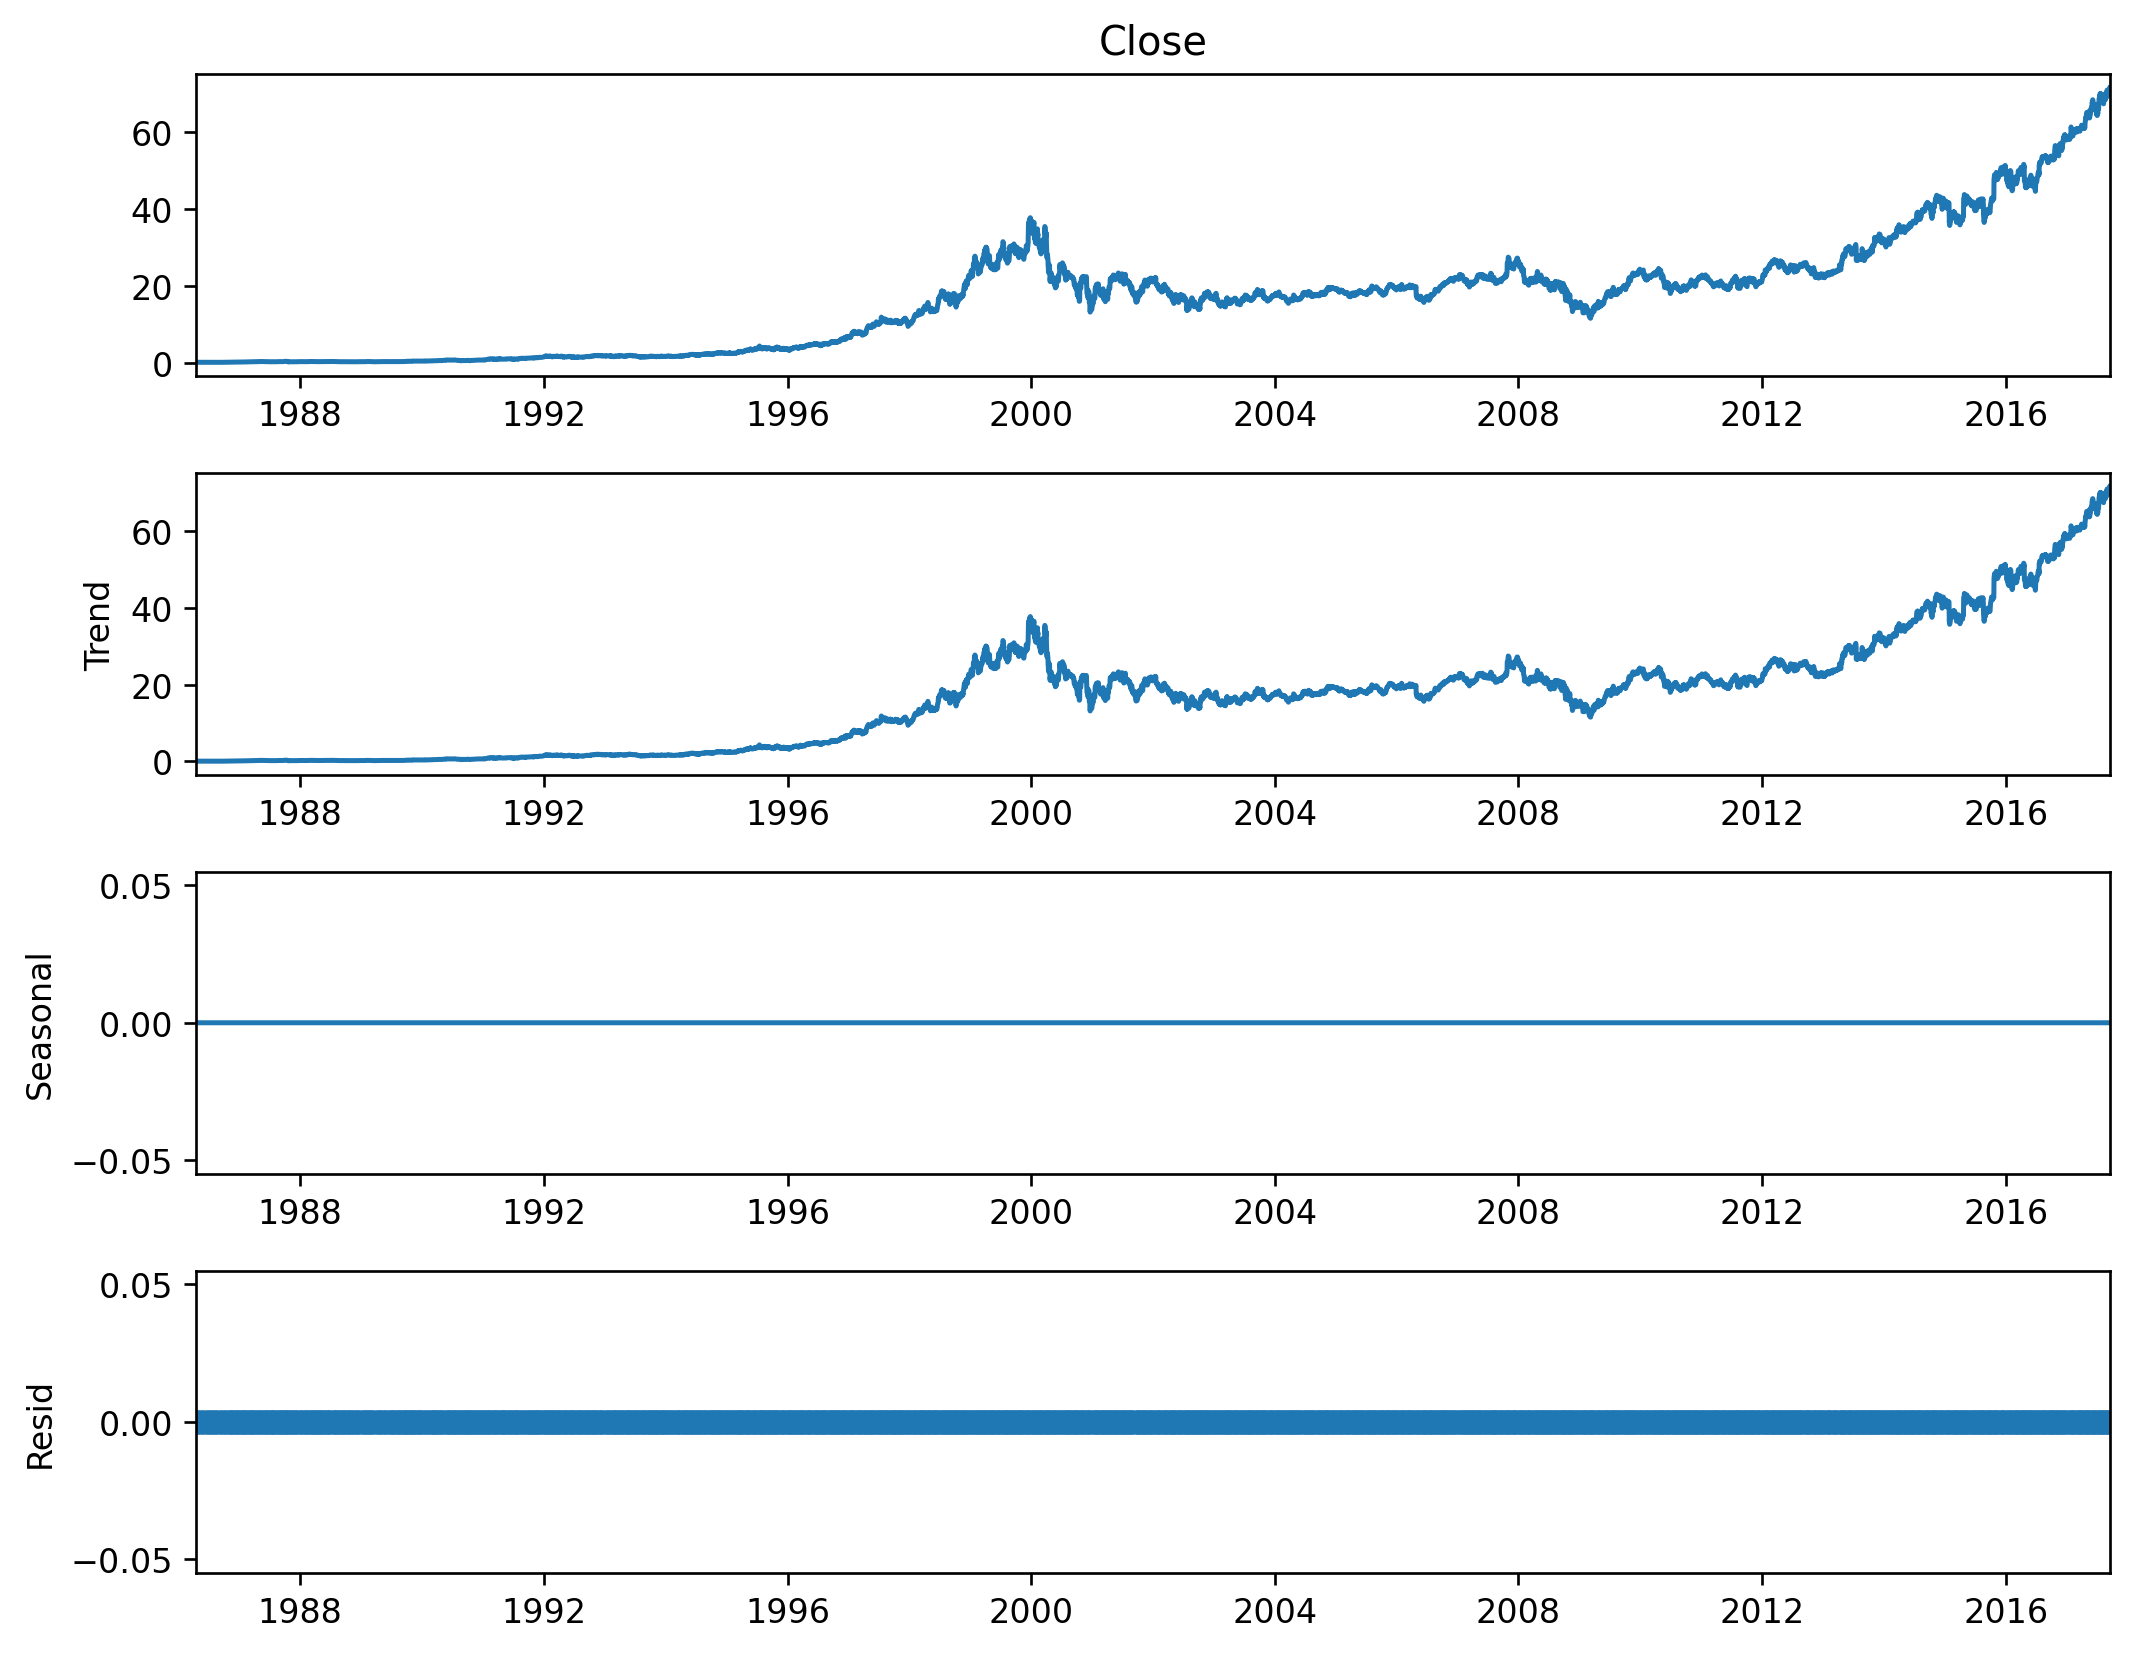

In [59]:
from statsmodels.tsa.seasonal import seasonal_decompose
def test_stationarity(df, ts):
    # Determing rolling statistics

    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(df[ts], autolag='AIC')  # add kpss
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '# Lags Used', 'Number of Observations Used'])

    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    

    if (dfoutput[0] < 0.05) :
        print("\nTime Series Stationary as P value ( {} ) < 0.05".format(round(dftest[1],5)))
    else:
        print("\nTime Series is not Stationary as P value ( {} ) > 0.05".format(round(dftest[1],5)))

    return dfoutput

result = seasonal_decompose(trainMinmax["Close"], model='additive', freq=1)
result.plot()
plt.show()

In [60]:
print(test_stationarity(trainMinmax,"Close"))
print(test_stationarity(trainMinmax,"Return"))

Results of Dickey-Fuller Test:

Time Series is not Stationary as P value ( 0.99897 ) > 0.05
Test Statistic                    2.327120
p-value                           0.998972
# Lags Used                      36.000000
Number of Observations Used    7686.000000
Critical Value (1%)              -3.431201
Critical Value (5%)              -2.861916
Critical Value (10%)             -2.566970
dtype: float64
Results of Dickey-Fuller Test:

Time Series Stationary as P value ( 0.0 ) < 0.05
Test Statistic                  -47.044395
p-value                           0.000000
# Lags Used                       3.000000
Number of Observations Used    7719.000000
Critical Value (1%)              -3.431197
Critical Value (5%)              -2.861915
Critical Value (10%)             -2.566969
dtype: float64


### Autocorrelation and Partial Autocorrelation

the time series reaches stationarity with two orders of differencing


<Figure size 1080x840 with 0 Axes>

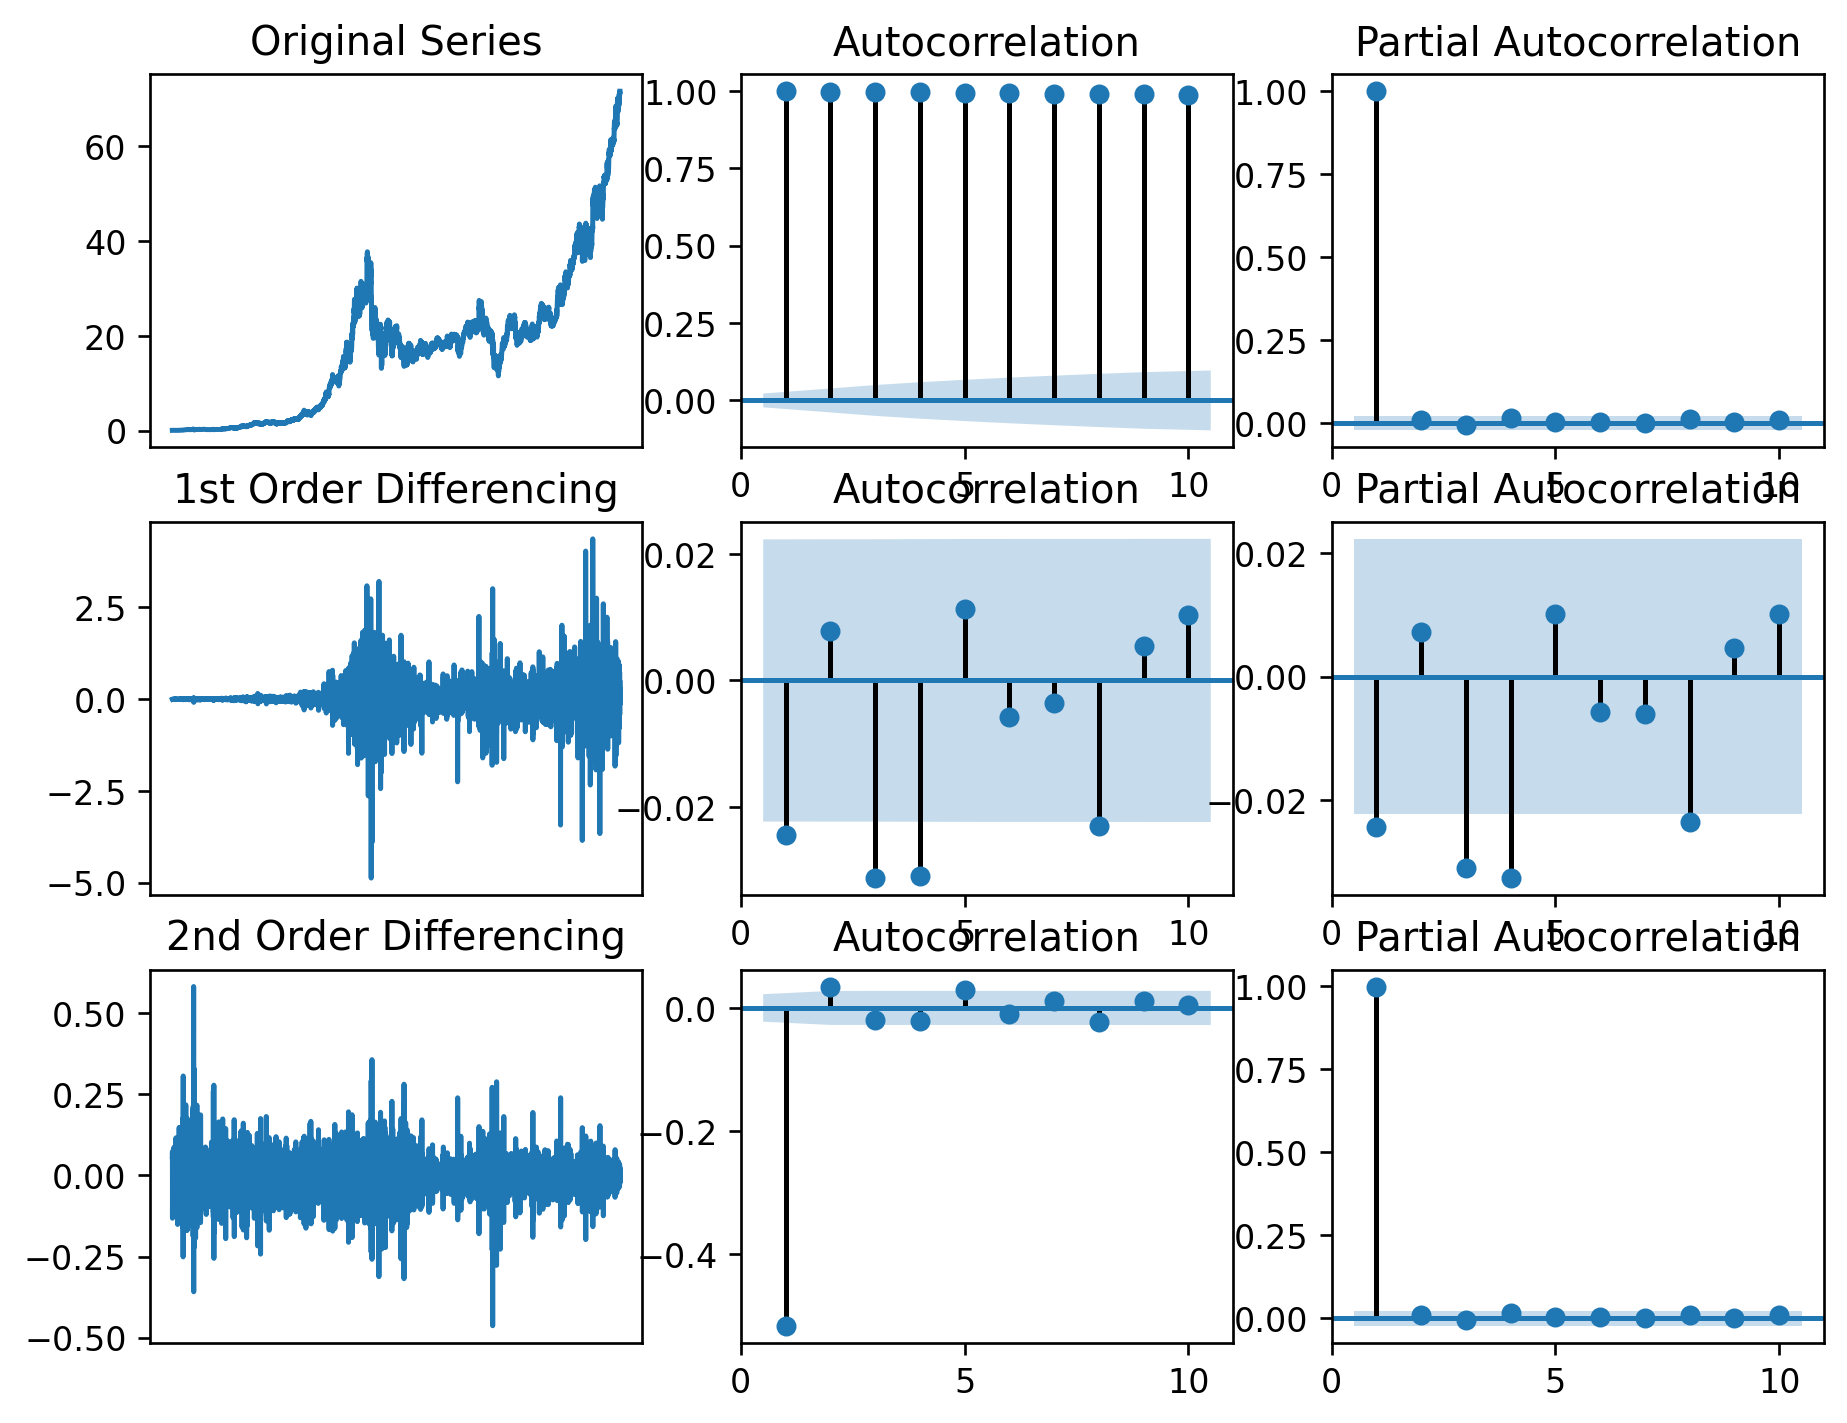

In [61]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
plt.subplots_adjust(top = 1, bottom=0.1, hspace=1.5, wspace=0.4)
# Import data

print ( "the time series reaches stationarity with two orders of differencing")

# Original Series
fig, axes = plt.subplots(3, 3, sharex=False)
axes[0, 0].axes.xaxis.set_visible(False)
axes[0, 0].plot(trainMinmax["Close"])
axes[0, 0].set_title('Original Series')
plot_acf(trainMinmax["Close"], ax=axes[0, 1],lags=10, zero=False)
plot_pacf(trainMinmax["Close"], ax=axes[0, 2],lags=10, zero=False)


# 1st Differencing
axes[1, 0].axes.xaxis.set_visible(False)
axes[1, 0].plot(trainMinmax["Close"].diff().dropna()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(trainMinmax.Close.diff().dropna(), ax=axes[1, 1],lags=10, zero=False)
plot_pacf(trainMinmax.Close.diff().dropna(),ax=axes[1, 2],lags=10, zero=False)

# 2nd Differencing
axes[2, 0].axes.xaxis.set_visible(False)
axes[2, 0].plot(trainMinmax.Return.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(trainMinmax.Close.diff().dropna().diff().dropna(), ax=axes[2, 1],lags=10, zero=False)
plot_pacf(trainMinmax["Close"], ax=axes[2, 2],lags=10, zero=False)

plt.show()

### Predict Using  ARIMA Model

### List of  indicators used for modeling 
- ['Mkt-RF','RF','SMB','HML','26ema','momentumLag_1','upper_band','momentumLag_3','sma_21','MACDLag_2']

In [62]:
exog = ['Mkt-RF','RF','SMB','HML','26ema','momentumLag_1','upper_band','momentumLag_3','sma_21','MACDLag_2']

### Function to verify change in MSE on additon of independent variables 

In [63]:
from statsmodels.tsa.arima_model import ARIMA
col_list = []
d  = trainMinmax
print("Mean Square error "," | List of Columns")
for i in exog:
    col_list.append(i)
    model = ARIMA(trainMinmax["Return"], exog=trainMinmax[col_list], order=(1, 0, 2))   
    model_fit = model.fit() 
    fc, se, conf = model_fit.forecast(d["Return"].shape[0],exog = d[col_list], alpha=0.05)  
    mse = mean_squared_error(d["Return"], fc)
    print(mse, "|", col_list)

Mean Square error   | List of Columns
0.0002987019481827815 | ['Mkt-RF']
0.0002982602108362398 | ['Mkt-RF', 'RF']
0.00029419162911415884 | ['Mkt-RF', 'RF', 'SMB']
0.00027956607282807145 | ['Mkt-RF', 'RF', 'SMB', 'HML']
0.0002794482407367184 | ['Mkt-RF', 'RF', 'SMB', 'HML', '26ema']
0.00027948334832374633 | ['Mkt-RF', 'RF', 'SMB', 'HML', '26ema', 'momentumLag_1']
0.0002793860960728092 | ['Mkt-RF', 'RF', 'SMB', 'HML', '26ema', 'momentumLag_1', 'upper_band']
0.00027938727075956394 | ['Mkt-RF', 'RF', 'SMB', 'HML', '26ema', 'momentumLag_1', 'upper_band', 'momentumLag_3']
0.00027884352083331016 | ['Mkt-RF', 'RF', 'SMB', 'HML', '26ema', 'momentumLag_1', 'upper_band', 'momentumLag_3', 'sma_21']
0.00027059303800007245 | ['Mkt-RF', 'RF', 'SMB', 'HML', '26ema', 'momentumLag_1', 'upper_band', 'momentumLag_3', 'sma_21', 'MACDLag_2']


#### List of Parameters used for modeling based on above result. Adding Lag variables has decreased MSE 
- ['Mkt-RF', 'RF', 'SMB', 'HML', '26ema', 'momentumLag_1', 'upper_band', 'momentumLag_3', 'sma_21','MACDLag_2']

## P and Q value for ARIMA modeling 
-- Using beow code we will very best P and Q value for our model

In [64]:
model = pm.auto_arima(trainMinmax["Return"], exogenous=pd.DataFrame(trainMinmax[exog]),
                      start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-41509.949, Time=5.84 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-41504.340, Time=8.33 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-41511.403, Time=8.17 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-41512.181, Time=4.90 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-41505.589, Time=17.20 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-41522.858, Time=13.21 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-41532.324, Time=16.42 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-41529.392, Time=17.41 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-41531.978, Time=21.94 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-41532.417, Time=17.98 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-41534.223, Time=7.59 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-41524.689, Time=6.24 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-41533.695, Time=8.56 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-41534.022, Time=8.96 sec

### Conclusion on selection of P and Q value 
- From above, we see that (0,0,3) and (1,0,2) this are two best P and Q values for the select model with same AIC score.
- Comparing Log Likelihood of both the models (20781.112,20779.899 ) are almost the same . Hence for this project we will proceed with (1,0,2) so that we can have both AR and MA lags as part of our modeling 


In [25]:
model = ARIMA(trainMinmax["Return"],exog=trainMinmax[exog], order=(1 , 0, 2))   
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Return   No. Observations:                 7723
Model:                     ARMA(1, 2)   Log Likelihood               20779.899
Method:                       css-mle   S.D. of innovations              0.016
Date:                Fri, 16 Jul 2021   AIC                         -41529.798
Time:                        15:48:19   BIC                         -41425.519
Sample:                             0   HQIC                        -41494.042
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0006      0.000      1.265      0.206      -0.000       0.002
Mkt-RF            0.0112      0.000     65.569      0.000       0.011       0.011
RF                0.0517      0.022      2.403      0.016       0.010       0.094
SMB              -0.0031      0.000     -9.632      0.000      -0.004      -0.002
HML              -0.0062      0.000    -19.217      0.000      -0.007      -0.006
26ema            -0.0385      0.002    -15.899      0.000      -0.043      -0.034
momentumLag_1    -0.0051      0.000    -11.755      0.000      -0.006      -0.004
upper_band       -0.0003      0.000     -1.452      0.146      -0.001       0.000
momentumLag_3    -0.0028      0.000     -7.699      0.000      -0.003      -0.002
sma_21            0.0388      0.002     16.101      0.000       0.034       0.044
MACDLag_2        -0.0426      0.003    -15.638      0.000      -0.048      -0.037
ar.L1.Return      0.8285      0.057     14.462      0.000       0.716       0.941
ma.L1.Return     -0.7936      0.057    -13.932      0.000      -0.905      -0.682
ma.L2.Return     -0.0591      0.013     -4.666      0.000      -0.084      -0.034
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2070           +0.0000j            1.2070            0.0000
MA.1            1.1600           +0.0000j            1.1600            0.0000
MA.2          -14.5926           +0.0000j           14.5926            0.5000
-----------------------------------------------------------------------------
"""

### Plot residual errors - Verifify Residual has constant mean and variance 


 Constant  mean and variance observed


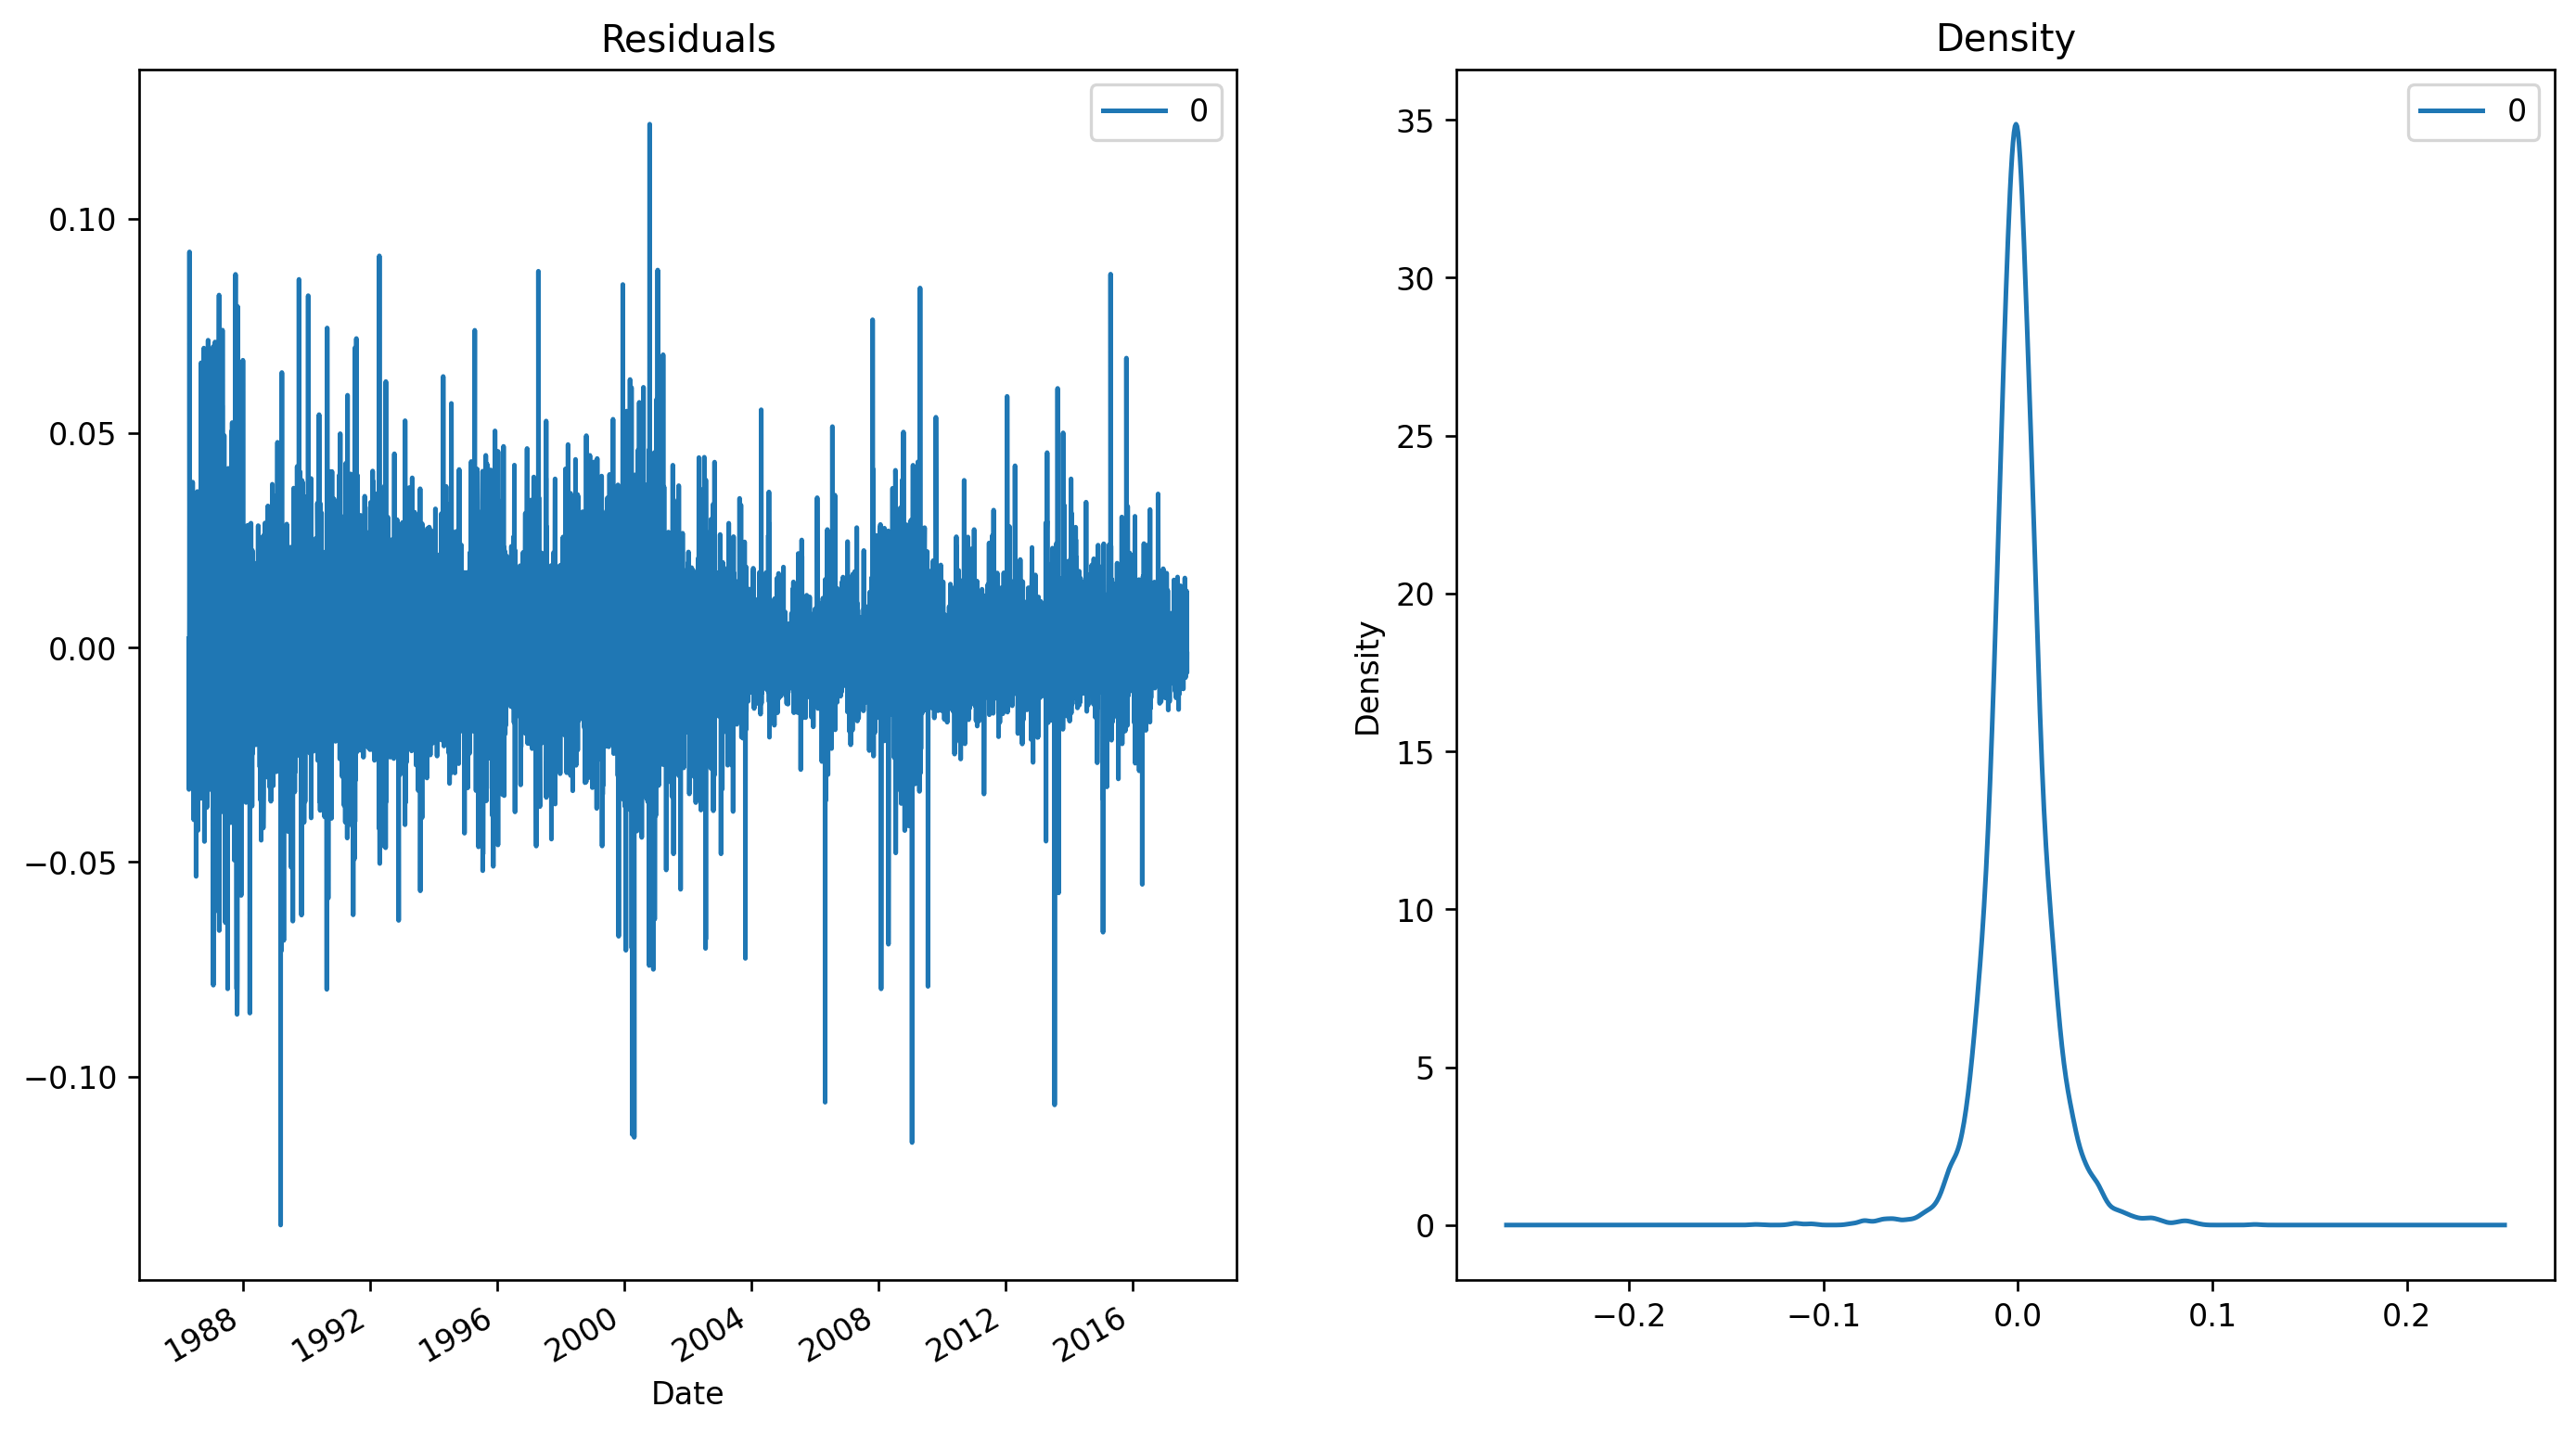

In [26]:

residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(14,8))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
print ( "\n Constant  mean and variance observed")
plt.show()

### Comparision ARIMA :  Actual Vs Fitted 

<Figure size 600x480 with 0 Axes>

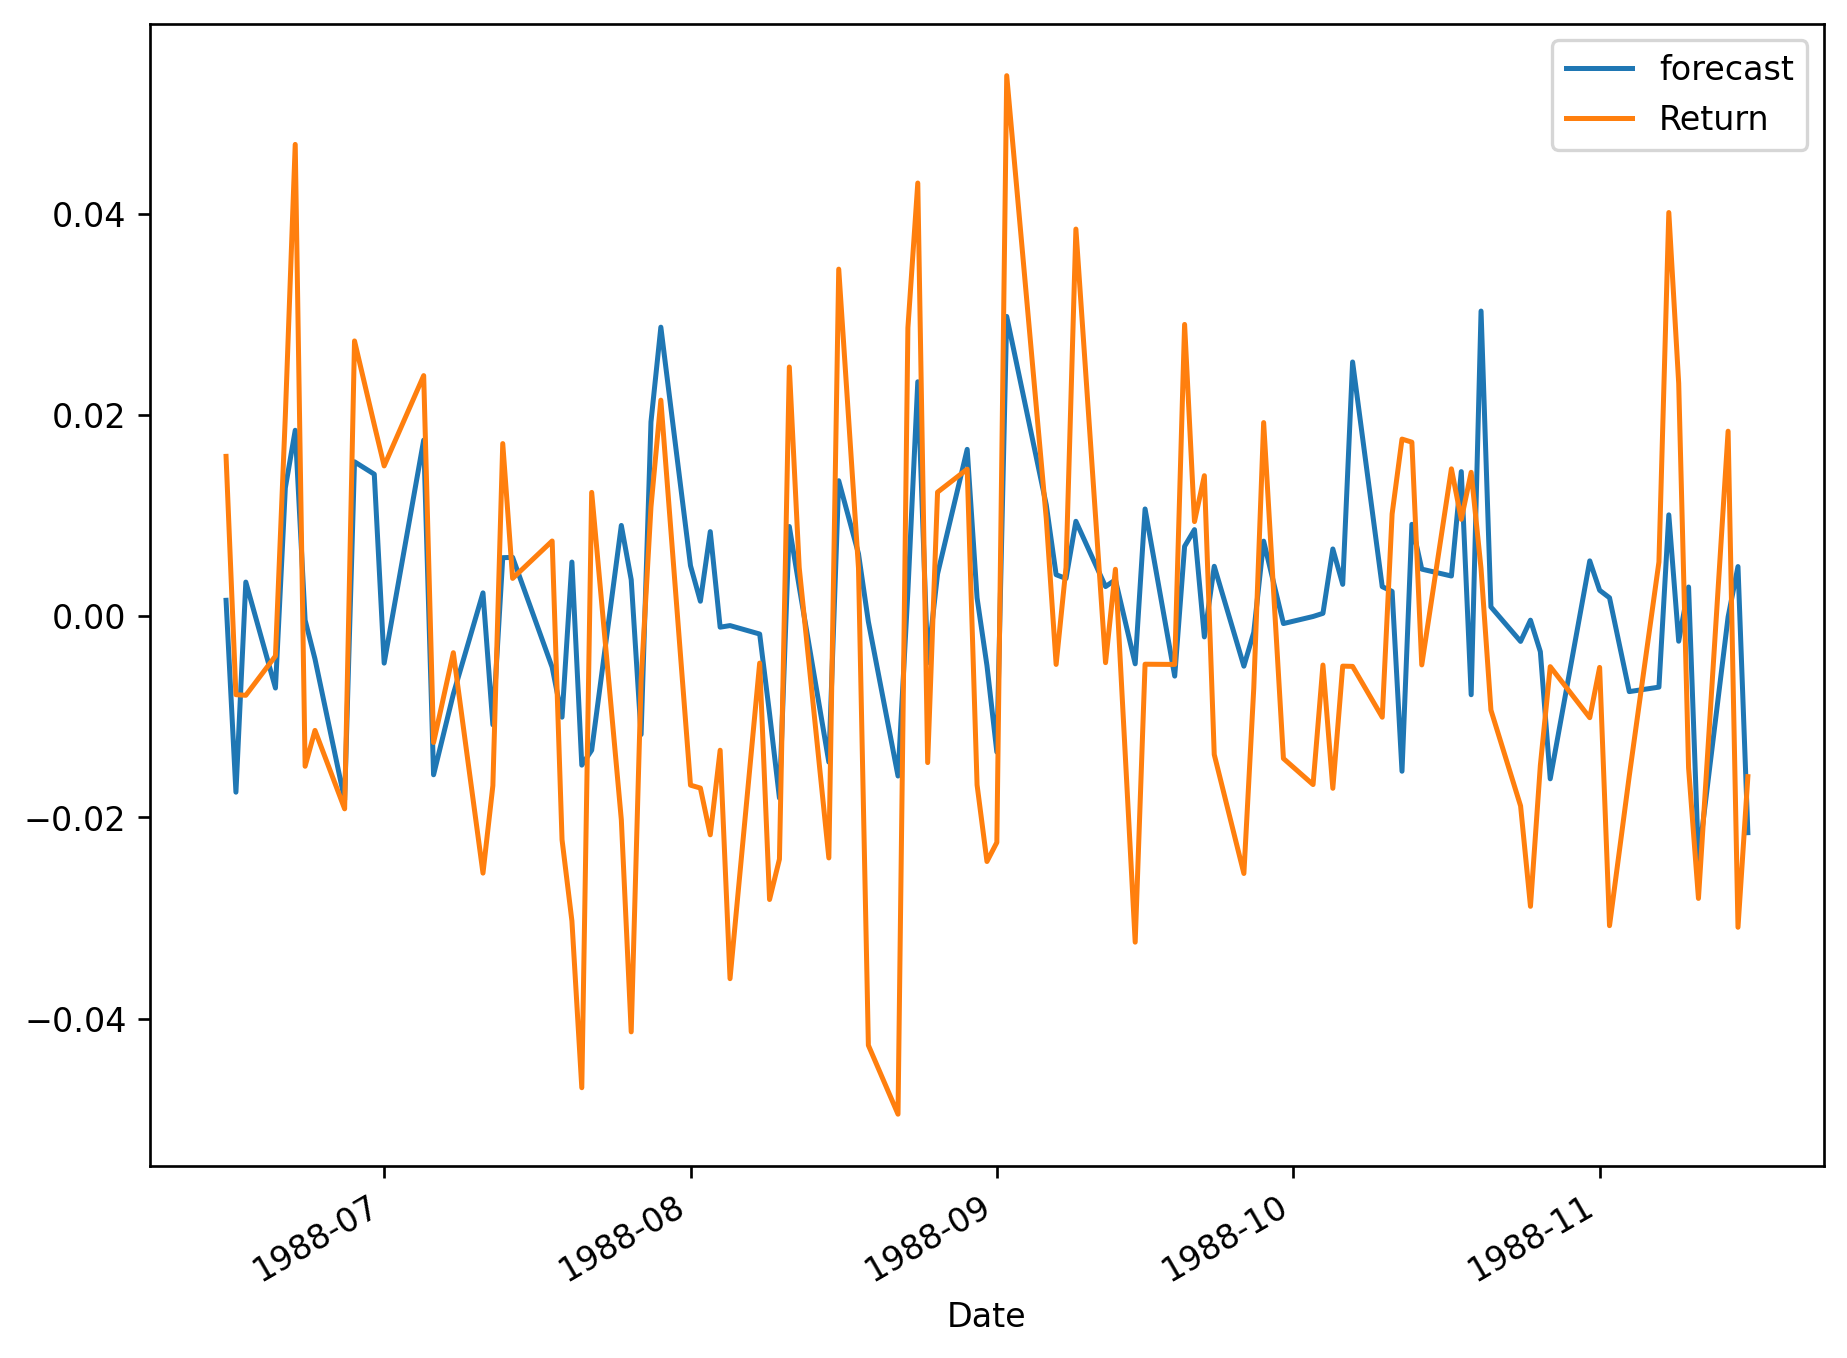

In [27]:
plt.figure(figsize=(5,4))
model_fit.plot_predict(dynamic=False, start=500, end=600)
plt.show()

## Forecasting 

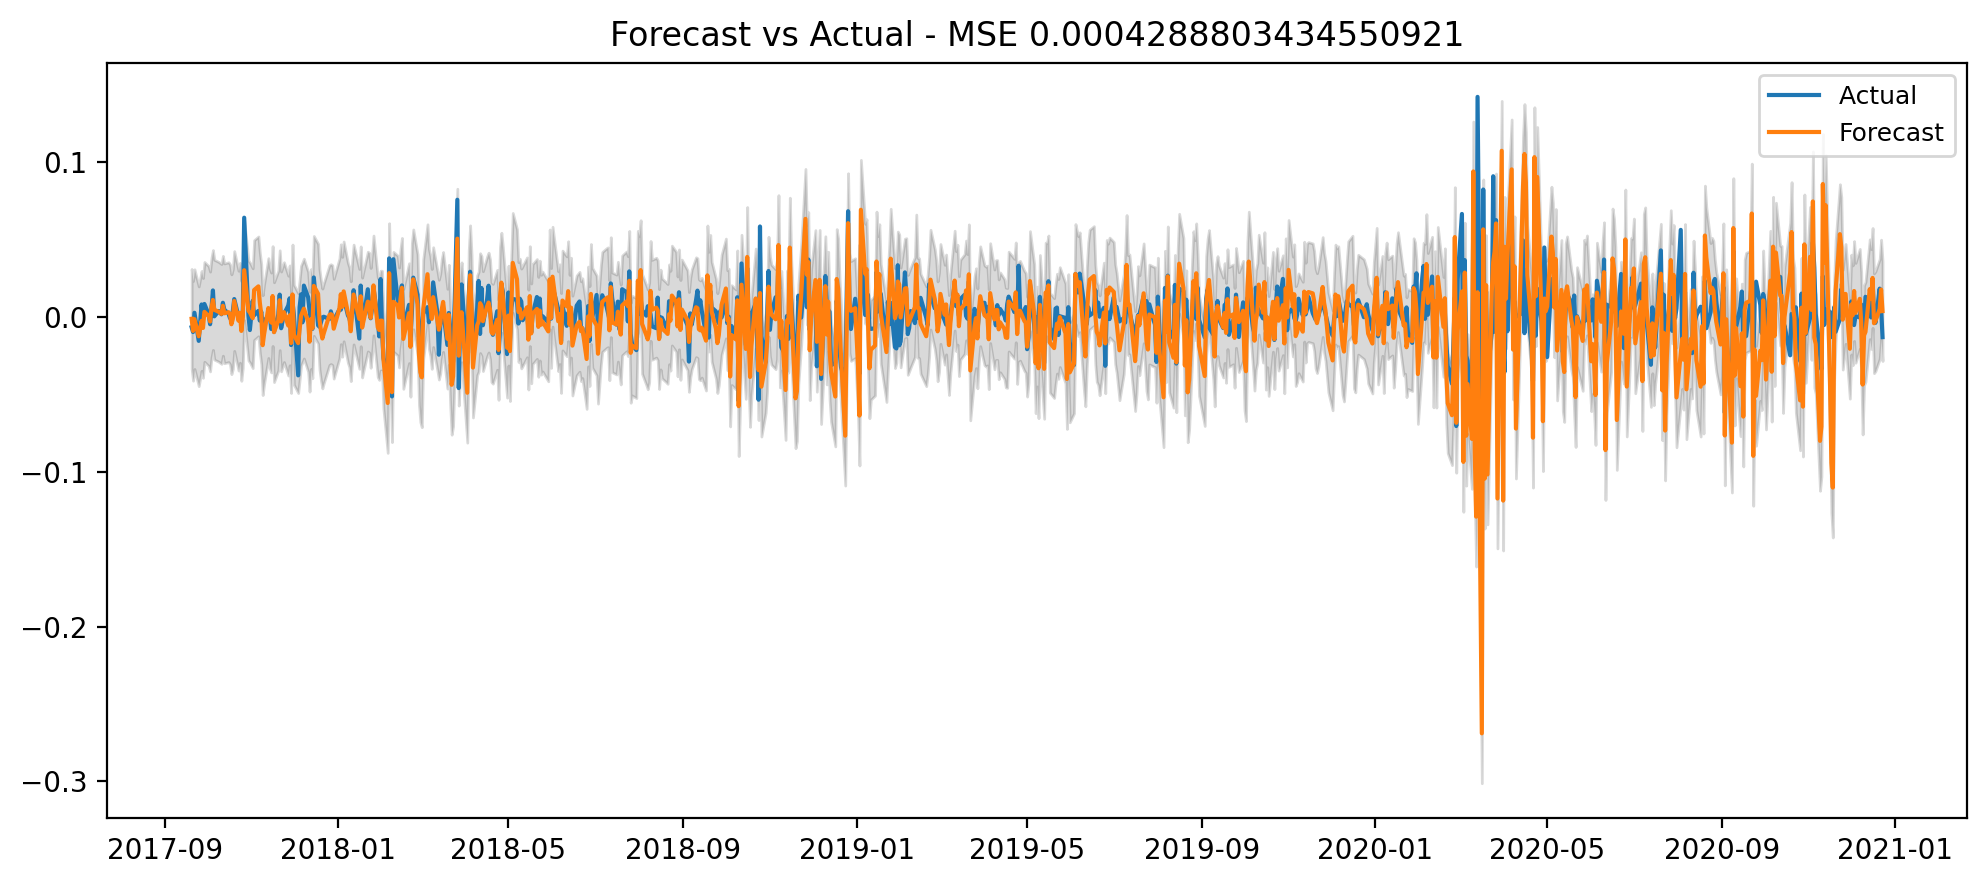

In [28]:
fc, se, conf = model_fit.forecast(valMinmax["Return"].shape[0], exog=valMinmax[exog], alpha=0.05)

# Make as pandas series
fc_series = pd.Series(fc, index=valMinmax.index)
lower_series = pd.Series(conf[:, 0], index=valMinmax.index)
upper_series = pd.Series(conf[:, 1], index=valMinmax.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(valMinmax["Return"], label='Actual ')
plt.plot(fc_series, label='Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actual - MSE {}'.format(mean_squared_error(valMinmax["Return"], fc)))
plt.legend(loc='upper right', fontsize=9)
plt.show()


### Accuracy metrics

In [29]:

from statsmodels.tsa.stattools import acf, pacf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-valMinmax["Return"])[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, valMinmax["Return"])

{'mape': 5.281918348988756,
 'me': -0.0030948517842444376,
 'mae': 0.013785490824133604,
 'mpe': -1.0430636625795668,
 'rmse': 0.02070942643954902,
 'acf1': 0.24866593982799914,
 'corr': 0.7159323332856339,
 'minmax': 1.523597030460161}

## GRAPH

PNL  - ARIMA
            ARIMA_Cumulative_PNL
Date                            
2020-01-02              0.025306
2020-01-03              0.013927
2020-01-06              0.021112
2020-01-07              0.004177
2020-01-08              0.013080


PNL-  DRL 
            DRL_Cumulative_PNL
Date                          
2020-01-02            0.002721
2020-01-03           -0.001366
2020-01-06           -0.000309
2020-01-07           -0.006181
2020-01-08            0.005355


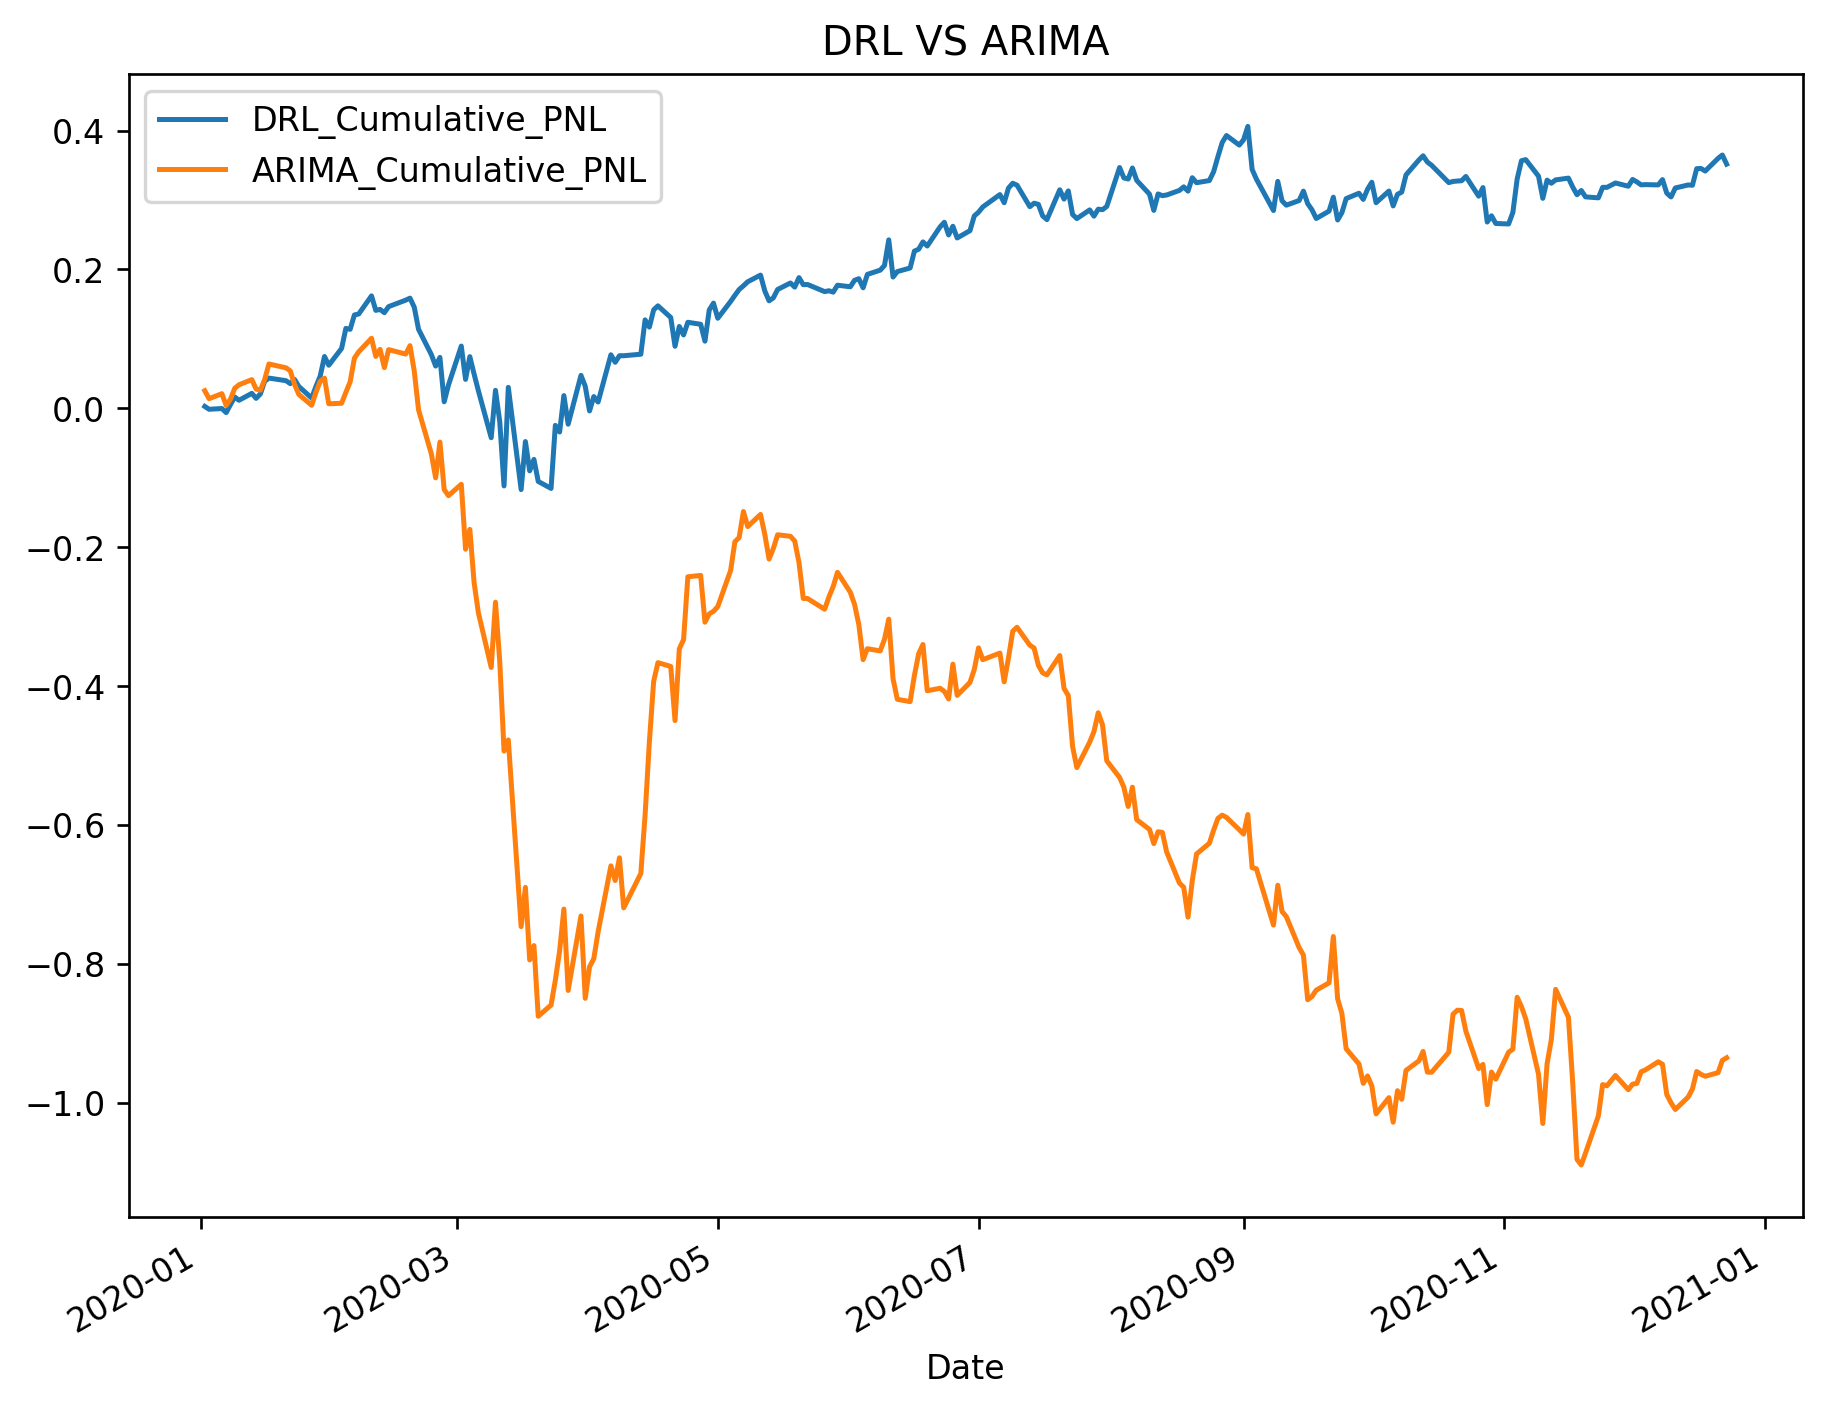

In [42]:
## ARIMA PNL 
pnl_df =  pd.DataFrame(fc, index = valMinmax[["Return"]].index)
pnl_df.columns = ["ARIMA_Forecast"]
pnl_df = pd.concat([pnl_df,valMinmax[["Return"]]], ignore_index = False ,axis =1)
pnl_df.columns = ["ARIMA_Forecast","Actual_MSFT_return"]
pnl_df = pnl_df[pnl_df.index.year == 2020]
pnl_df["ARIMA_Cumulative_PNL"] =  pnl_df["ARIMA_Forecast"].cumsum()
print("PNL  - ARIMA")
print(pnl_df[["ARIMA_Cumulative_PNL"]].head(5))

### DRL PNL
PNL_DRL_df = pd.read_csv("pnl.csv")
PNL_DRL_df.reset_index().drop("index",axis =1)
PNL_DRL_df.date = pd.to_datetime(PNL_DRL_df.date.apply(lambda x : str(x).replace("00:00:00+00:00","")))
PNL_DRL_df.columns = ["Date","DRL_Cumulative_PNL"]
PNL_DRL_df = PNL_DRL_df.set_index("Date")
print("\n\nPNL-  DRL ")
print(PNL_DRL_df.head(5))

## Graph

df_PNL = pd.concat([PNL_DRL_df,pnl_df[["ARIMA_Cumulative_PNL"]]],ignore_index = False, join = "inner",axis =1)
df_PNL.plot(title = "DRL VS ARIMA")
plt.show()
